# Ramdom Forest

Es un algoritmo capas de realizar tanto de regresión como de clasificación con el uso de múltiples árboles de decisión, la idea básica de esto es tener varios árboles de decisión para calcular el resultado final en vez de depender de solo uno.

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/v1677239993/image5_c214968fd6.png" width="1800">

En la imagen anterior tenemos diversos árboles de decisión, cada árbol está expuesto a un número diferente características y diferentes conjuntos iniciales, cada árbol obtiene una predicción donde los círculos verdes indican el camino para llegar a esa predicción

# Ejercicio

predecir la temperatura máxima para mañana en una determinada ciudad usando un año de datos meteorológicos anteriores.

Variables del estudio:

- year: 2016 para todos los puntos de datos
- month: número del mes del año
- day: número para el día del año
- week: día de la semana como cadena de caracteres
- temp_2: temperatura máxima 2 días antes
- temp_1: temperatura máxima 1 día antes
- average: temperatura máxima promedio histórica
- actual: medición de temperatura máxima
- friend: la predicción de tu amigo, un número aleatorio entre 20 por debajo del promedio y 20 por encima del promedio

Estoy trabajando en colaboratory es una herramienta de google para ver python notebooks

la [data](https://github.com/mauricio-alexis-casanova-valdenegro/machine-learning-clasico/blob/main/supervisado/Ramdom_Forest_regresion/temps.csv) esta alojada en Github

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, mean_squared_error,mean_absolute_error
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# carga y limpieza de datos

In [7]:
arbol = pd.read_csv('/content/temps.csv' , sep = ",")

#.drop('week',axis=1).drop('year',axis=1).drop('month',axis=1).drop('day',axis=1)
arbol.isna

<bound method DataFrame.isna of      year  month  day   week  temp_2  temp_1  average  actual  forecast_noaa  \
0    2016      1    1    Fri      45      45     45.6      45             43   
1    2016      1    2    Sat      44      45     45.7      44             41   
2    2016      1    3    Sun      45      44     45.8      41             43   
3    2016      1    4    Mon      44      41     45.9      40             44   
4    2016      1    5   Tues      41      40     46.0      44             46   
..    ...    ...  ...    ...     ...     ...      ...     ...            ...   
343  2016     12   27   Tues      42      42     45.2      47             41   
344  2016     12   28    Wed      42      47     45.3      48             41   
345  2016     12   29  Thurs      47      48     45.3      48             43   
346  2016     12   30    Fri      48      48     45.4      57             44   
347  2016     12   31    Sat      48      57     45.5      40             42   

     fo

In [8]:
arbol.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


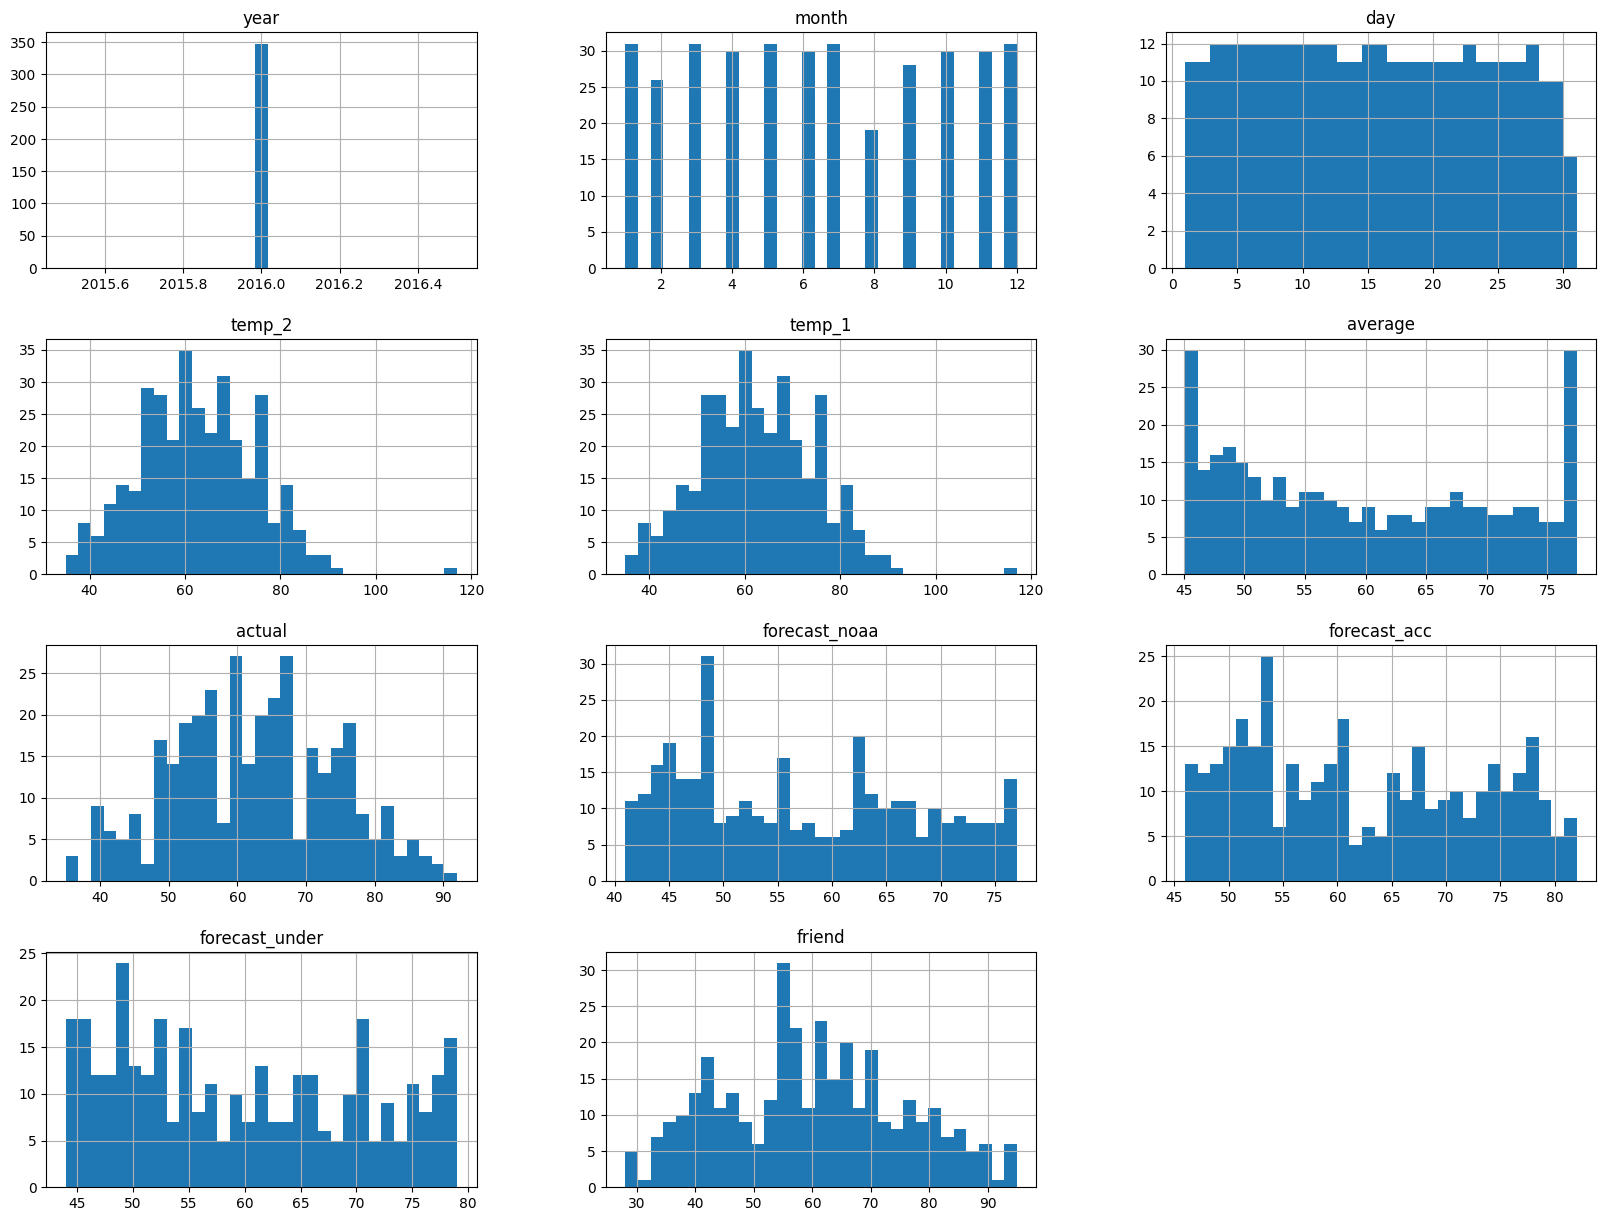

In [9]:
#histogramas
arbol.hist(bins=31,figsize=(20,15));

las variables month y day tieneden a tener un comportamiento uniforme, temp_1 y temp_2 al parecer son de distribucion normal con asimetria hacia la izquerda, tambien tienen un dato extremo.

### buscamos datos extremos visto en las curvas

In [10]:
arbol.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [11]:
arbol.temp_1[arbol.temp_1 > 92]

286    117
Name: temp_1, dtype: int64

In [ ]:
arbol.temp_2[arbol.temp_2 > 92]

287    117
Name: temp_2, dtype: int64

In [ ]:
arbol.iloc[[286,287],:]

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
286,2016,10,31,Mon,65,117,54.8,59,51,59,56,62
287,2016,11,1,Tues,117,59,54.5,57,51,59,55,61


In [ ]:
#eliminamos las temperaturas extremas
arbol = arbol[(arbol.temp_1 != 117) & (arbol.temp_2 != 117)]
arbol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            346 non-null    int64  
 1   month           346 non-null    int64  
 2   day             346 non-null    int64  
 3   week            346 non-null    object 
 4   temp_2          346 non-null    int64  
 5   temp_1          346 non-null    int64  
 6   average         346 non-null    float64
 7   actual          346 non-null    int64  
 8   forecast_noaa   346 non-null    int64  
 9   forecast_acc    346 non-null    int64  
 10  forecast_under  346 non-null    int64  
 11  friend          346 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 35.1+ KB


<ipython-input-110-4288e8e1a974>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = arbol.corr(method='pearson')


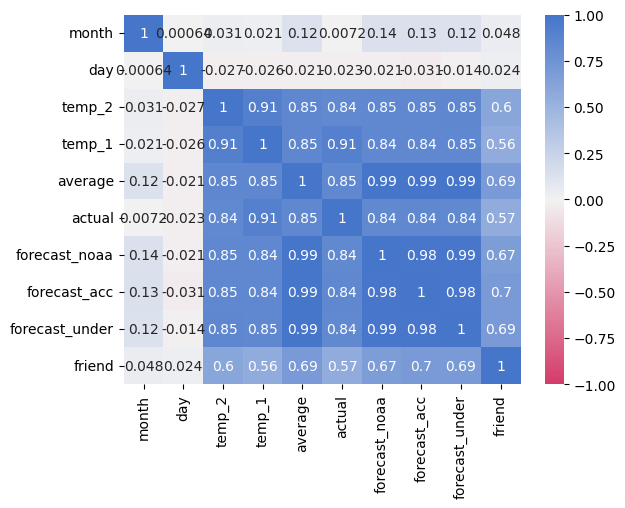

In [ ]:
arbol = arbol.drop(['year'],axis=1)

#correlaciones de los datos
corr_matrix = arbol.corr(method='pearson')

#graficamos la matriz de correlacion
sns.heatmap(corr_matrix,annot=True,linewidths=0,vmin=-1,vmax=1,cmap= sns.diverging_palette(0, 255, n=200));

## 2

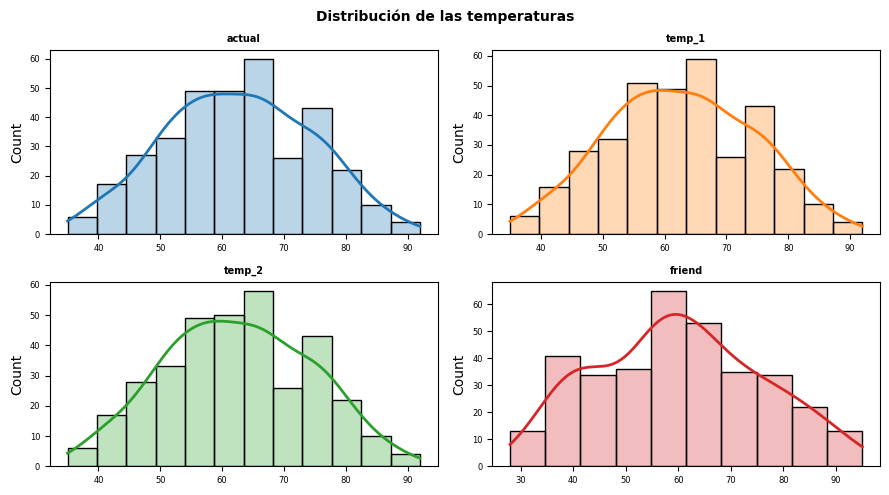

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = arbol.loc[:,["actual", "temp_1",	"temp_2",	"friend"]]
for i, colum in enumerate(columnas_numeric):
    sns.histplot(data = arbol,x = colum,stat = "count",kde = True,color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],line_kws = {'linewidth': 2},alpha= 0.3,ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución de las temperaturas', fontsize = 10, fontweight = "bold");

In [ ]:
temperaturas_clean = arbol.drop(columns=['forecast_noaa', 'forecast_acc', 'forecast_under'])
temperaturas_clean=pd.get_dummies(temperaturas_clean)
temperaturas_clean.info()
temperaturas_clean.iloc[:,7:14] = temperaturas_clean.iloc[:,7:14].astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 347
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       346 non-null    int64  
 1   day         346 non-null    int64  
 2   temp_2      346 non-null    int64  
 3   temp_1      346 non-null    int64  
 4   average     346 non-null    float64
 5   actual      346 non-null    int64  
 6   friend      346 non-null    int64  
 7   week_Fri    346 non-null    uint8  
 8   week_Mon    346 non-null    uint8  
 9   week_Sat    346 non-null    uint8  
 10  week_Sun    346 non-null    uint8  
 11  week_Thurs  346 non-null    uint8  
 12  week_Tues   346 non-null    uint8  
 13  week_Wed    346 non-null    uint8  
dtypes: float64(1), int64(6), uint8(7)
memory usage: 24.0 KB


<ipython-input-112-50862bc98a03>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  temperaturas_clean.iloc[:,7:14] = temperaturas_clean.iloc[:,7:14].astype(int)


In [ ]:
temperaturas_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 347
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       346 non-null    int64  
 1   day         346 non-null    int64  
 2   temp_2      346 non-null    int64  
 3   temp_1      346 non-null    int64  
 4   average     346 non-null    float64
 5   actual      346 non-null    int64  
 6   friend      346 non-null    int64  
 7   week_Fri    346 non-null    int64  
 8   week_Mon    346 non-null    int64  
 9   week_Sat    346 non-null    int64  
 10  week_Sun    346 non-null    int64  
 11  week_Thurs  346 non-null    int64  
 12  week_Tues   346 non-null    int64  
 13  week_Wed    346 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 40.5 KB


In [ ]:
# Separación de data

X = temperaturas_clean.drop('actual', axis=1)
y = temperaturas_clean['actual']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 42)

In [ ]:
media = np.mean(temperaturas_clean.actual)
media

62.56936416184971

In [ ]:
# Ajuste del modelo

modelo = RandomForestRegressor(n_estimators=196,random_state=42)

modelo.fit(X_train, y_train)

RandomForestRegressor(n_estimators=196, random_state=42)

Dado que siempre el ramdomforest se genera con los mismos datos se puede calcular la cantidad de experimentos maximos que puede necesitar para generar cada estado.

tenemos que de cada nodo van a salir 2 ramas,osea que va a prograsar asi {1,2,4,16} por lo que seria una progresion $d^2$ donde $d$ es la dimension, en este caso la dimension es cuantas columnas tiene, por lo que seria $14^2=196$

si tenemos de que en cada nodo va a salir 3 ramas eso seria $d^3$ por lo que si generalizamos seria $d^n$ donde $d$ corresponde a la dimension y $n$ el numero de ramas, si y solo si el random state es un numero fijo

In [ ]:
# Predicciones
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {round(rmse,2)}")

El error (rmse) de test es: 5.06


In [ ]:
mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones)

mse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = True
       )

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )

print(f"El error (mae) de test es: {mae} \n El error (mse) de test es: {mse} \n El error (rmse) de test es: {rmse}")

El error (mae) de test es: 3.889221205723668 
 El error (mse) de test es: 25.633780165831286 
 El error (rmse) de test es: 5.06298135151921


por lo que se aleja 5.06 del valor real, osea que el valor actual de temperatura puede variar entre -5 y 5, lo cual para mi es un mal modelo dado que la longitud del intervalo de error son aproximadamente 10.

se puede arreglar teniendo un set de datos mucho mas grande, no solo de un año, dado que randomforest funciona mejor con datas mas grandes, y la temperatura en diversas partes del mundo se esta midiendo desde 1850, por lo cual nos daria un error mucho menor.

ademas utilizaria el gradiente de temperatura, dado que el dato puedo ser sacado desde cualquier parte de la ciudad estudiada.